In [84]:
import pandas as pd
from ast import literal_eval
import nltk
import re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
!pip freeze | grep scipy

scipy==1.10.1


# Load Datasets

We load the preprocessed datasets. Make sure to run the previous notebooks first, so the files are present.

## media

In [5]:
df_media = pd.read_csv('../data/cleantech-media.csv', converters={"token_content": literal_eval}, parse_dates=['date'])
df_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9588 entries, 0 to 9587
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          9588 non-null   object        
 1   date           9588 non-null   datetime64[ns]
 2   author         31 non-null     object        
 3   content        9588 non-null   object        
 4   domain         9588 non-null   object        
 5   url            9588 non-null   object        
 6   token_content  9588 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 524.5+ KB


In [6]:
df_media.head(5)

,title,date,author,content,domain,url,token_content
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,Qatar Petroleum ( QP) is targeting aggressive ...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[qatar, petroleum, qp, target, aggress, cut, g..."
1,India Launches Its First 700 MW PHWR,2021-01-15,NaN,Nuclear Power Corp. of India Ltd. ( NPCIL) syn...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[nuclear, power, corp, india, ltd, npcil, sync..."
2,New Chapter for US-China Energy Trade,2021-01-20,NaN,New US President Joe Biden took office this we...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[new, us, presid, joe, biden, take, offic, wee..."
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,The slow pace of Japanese reactor restarts con...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[slow, pace, japanes, reactor, restart, contin..."
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,Two of New York City's largest pension funds s...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[two, new, york, citi, larg, pension, fund, sa..."


## patents

In [7]:
df_patents = pd.read_csv('../data/google_patents.csv', converters={"token_content": literal_eval}, parse_dates=['publication_date'])
df_patents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13199 entries, 0 to 13198
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   publication_number  13199 non-null  object        
 1   application_number  13199 non-null  object        
 2   country_code        13199 non-null  object        
 3   publication_date    13199 non-null  datetime64[ns]
 4   inventor            13199 non-null  object        
 5   title               13199 non-null  object        
 6   abstract            13199 non-null  object        
 7   abstract_lang       13199 non-null  object        
 8   token_content       13199 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 928.2+ KB


In [8]:
df_patents.head()

,publication_number,application_number,country_code,publication_date,inventor,title,abstract,abstract_lang,token_content
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,['en'],"[disclos, adapt, dc, ac, invert, system, oper,..."
1,US-2022239251-A1,US-202217580956-A,US,2022-07-28,[],System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",['en'],"[accord, exampl, embodi, solar, energi, system..."
2,US-11396827-B2,US-202117606042-A,US,2022-07-26,[],Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,['en'],"[control, method, optim, solar, power, effici,..."
3,CN-114772674-A,CN-202210500131-A,CN,2022-07-22,[],Low-carbon running saline wastewater treatment...,The invention discloses a system and a method ...,"['zh', 'en']","[invent, disclos, system, method, treat, low, ..."
4,CN-217026795-U,CN-202220668705-U,CN,2022-07-22,[],Water ecological remediation device convenient...,The utility model discloses a water ecological...,"['zh', 'en']","[util, model, disclos, water, ecolog, restor, ..."


# Pre-processing

Mostly taken form previous notebook, but without lemmatizing/stemming.

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_nltk = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pascal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def preprocess_text(text):

    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]+', '', text)

    # tokenize the text
    re_tokens = re.findall('[\w]+', text)

    # remove stopwords
    filtered_stopwords = []
    for word in re_tokens:
        if word.lower() not in stop_words_nltk:
            filtered_stopwords.append(word.lower())
        else:
            pass

    return filtered_stopwords

preprocess_text('This, my Friend, is a % test. Have I passed?')

['friend', 'test', 'passed']

In [26]:
%%timeit 
media_tokens = df_media['content'].apply(lambda x: preprocess_text(x))

7.7 s ± 87.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
media_tokens[:10]

0    [qatar, petroleum, qp, targeting, aggressive, ...
1    [nuclear, power, corp, india, ltd, npcil, sync...
2    [new, us, president, joe, biden, took, office,...
3    [slow, pace, japanese, reactor, restarts, cont...
4    [two, new, york, citys, largest, pension, fund...
5    [japans, supreme, court, likely, become, arbit...
6    [oil, natural, gas, industry, officials, looki...
7    [new, great, game, emerging, energy, business,...
8    [close, th, anniversary, fukushima, daiichi, d...
9    [coldest, weather, generation, brought, widesp...
Name: content, dtype: object

In [61]:
# number of words
len([word for sublist in media_tokens for word in sublist])

4314610

In [58]:
# number of unique words
len(set([word for sublist in media_tokens for word in sublist]))

87078

In [28]:
%%timeit 
patent_tokens = df_patents['abstract'].apply(lambda x: preprocess_text(x))

2.64 s ± 37.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
patent_tokens[:10]

0    [adaptable, dcac, inverter, drive, system, ope...
1    [system, providing, energy, single, contiguous...
2    [control, method, optimizing, solartopower, ef...
3    [lowcarbon, running, saline, wastewater, treat...
4    [water, ecological, remediation, device, conve...
5    [cold, hot, medium, energy, storage, hot, wate...
6    [solar, energy, respiratory, wall, based, prin...
7    [vehiclemounted, hydrogen, energy, storage, eq...
8    [mobile, energy, storage, device, based, solar...
9    [solar, photovoltaic, aluminum, frame, protect...
Name: title, dtype: object

In [60]:
# number of words
len([word for sublist in patent_tokens for word in sublist])

95438

In [59]:
# number of unique words
len(set([word for sublist in patent_tokens for word in sublist]))

7158

# Generate Word Embeddings

## Train baseline model with default params

In [32]:
%%timeit
# train model with default params
media_embeddings_model = Word2Vec(sentences=media_tokens)

8.58 s ± 273 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit
# train model with default params
patent_embeddings_model = Word2Vec(sentences=patent_tokens)

159 ms ± 6.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
patent_embeddings_model = Word2Vec(sentences=patent_tokens)

## Evaluate the models

In [63]:
def nearest_words(word, top_n=10):
    print(f'Most similar words to "{word}" in both models')
    return pd.concat([
        pd.DataFrame(media_embeddings_model.wv.most_similar(word, topn=top_n), columns=['media_word', 'media_dist']), 
        pd.DataFrame(patent_embeddings_model.wv.most_similar(word, topn=top_n), columns=['patent_word', 'patent_dist'])
    ], axis=1)
    
nearest_words('solar')

Most similar words to "solar" in both models


,media_word,media_dist,patent_word,patent_dist
0,project,0.999390,forms,0.966895
1,mw,0.999308,utilizing,0.961341
2,renewables,0.999289,integrated,0.959665
3,first,0.999276,charging,0.958967
4,plant,0.999271,light,0.957541
5,plans,0.999256,charged,0.949420
6,launches,0.999255,new,0.947722
7,could,0.999232,complementary,0.945782
8,announces,0.999170,electric,0.945068
9,largest,0.999163,capable,0.942034


In [64]:
nearest_words("oil")

Most similar words to "oil" in both models


,media_word,media_dist,patent_word,patent_dist
0,drilling,0.998490,suitable,0.998339
1,natural,0.998454,transportation,0.997694
2,rig,0.997924,applied,0.997304
3,count,0.997802,soil,0.997177
4,us,0.997760,network,0.996956
5,patch,0.997655,field,0.996757
6,activity,0.997507,space,0.996749
7,gas,0.997204,rock,0.996580
8,futures,0.996260,online,0.996573
9,mexico,0.996066,fault,0.996567


In [155]:
nearest_words("sun")

Most similar words to "sun" in both models


,media_word,media_dist,patent_word,patent_dist
0,e,0.998402,tracking,0.995279
1,port,0.998152,foldable,0.994910
2,manufacturing,0.998137,novel,0.994770
3,tech,0.998127,mobile,0.994106
4,efficient,0.998125,improving,0.993901
5,design,0.998121,glass,0.993774
6,takes,0.998118,circuit,0.993296
7,facility,0.998115,adjusting,0.993251
8,nuclear,0.998076,rate,0.993043
9,partner,0.998052,efficiency,0.992930


In [66]:
media_embeddings_model.wv.similarity('oil', 'solar')

0.9916835

In [68]:
media_embeddings_model.wv.similarity('sun', 'solar')

0.9967104

In [75]:
media_embeddings_model.wv.similarity('renewable', 'solar')

0.9981366

In [74]:
media_embeddings_model.wv.similarity('renewable', 'oil')

0.98939914

In [65]:
patent_embeddings_model.wv.similarity('oil', 'solar')

0.7683153

In [67]:
patent_embeddings_model.wv.similarity('sun', 'solar')

0.9046115

In [195]:
patent_embeddings_model.wv.similarity('renewable', 'solar')

0.9026717

In [196]:
patent_embeddings_model.wv.similarity('renewable', 'oil')

0.95816344

### Get most frequent words and see their position in 2D-space


In [202]:
FREQUENCY = 50

In [203]:
# Use Counter to count occurrences of each word in both datasets combined
word_counts = Counter([word for sublist in media_tokens for word in sublist] + [word for sublist in patent_tokens for word in sublist])

# Get the most common words and their counts
most_common_words = word_counts.most_common(FREQUENCY)
most_common_words[:10]

[('energy', 66251),
 ('solar', 37321),
 ('power', 22330),
 ('new', 21231),
 ('gas', 19284),
 ('us', 17957),
 ('said', 16950),
 ('also', 15794),
 ('storage', 14502),
 ('data', 14269)]

In [207]:
media_word_vecs = []
patent_word_vecs = []
labels = []

for word, count in most_common_words:
    try:
        media_word_vecs.append(media_embeddings_model.wv.get_vector(word))
    except:
        media_word_vecs.append(np.empty(100,))
    try:
        patent_word_vecs.append(patent_embeddings_model.wv.get_vector(word))
    except:
        patent_word_vecs.append(np.empty(100,))
    labels.append(word)
    
media_word_vecs = np.array(media_word_vecs)
patent_word_vecs = np.array(patent_word_vecs)
    
(patent_word_vecs.shape, media_word_vecs.shape)

((50, 100), (50, 100))

In [209]:
# show sample word vector
patent_word_vecs[0]

array([-0.2784512 ,  0.67634696,  0.28766882,  0.48631474,  0.71663284,
       -1.09679639, -0.3005158 ,  1.27653849, -0.16902168, -0.59349585,
        0.20974171, -0.58758682, -0.22758752,  0.57671332,  0.31547737,
       -0.09997737, -0.01153724, -0.34102732, -0.20849034, -0.50171715,
       -0.0010302 ,  0.11139007,  0.92128605, -0.32109421,  0.42235526,
       -0.14334251, -0.5458374 ,  0.12889916,  0.06699963,  0.4920938 ,
        0.60204399, -0.63625705,  0.40000895, -0.17960018, -0.15057968,
        0.29616755,  0.24439842, -0.21952985, -0.03520032, -1.12160599,
       -0.15351994, -0.47100323, -0.64934278,  0.00551343,  0.20047966,
        0.48304886, -0.36827117, -0.07777036, -0.00047382,  0.24896185,
        0.56043333, -0.83512145, -0.37358233,  0.23826934, -0.27174744,
        0.2767548 ,  0.54281789,  0.44330323, -0.37823051,  0.53025079,
        0.03912139,  0.39334697,  0.71570629, -0.2156947 , -0.46236068,
        0.42186376,  0.45092759,  0.27626055, -0.85636067,  0.58

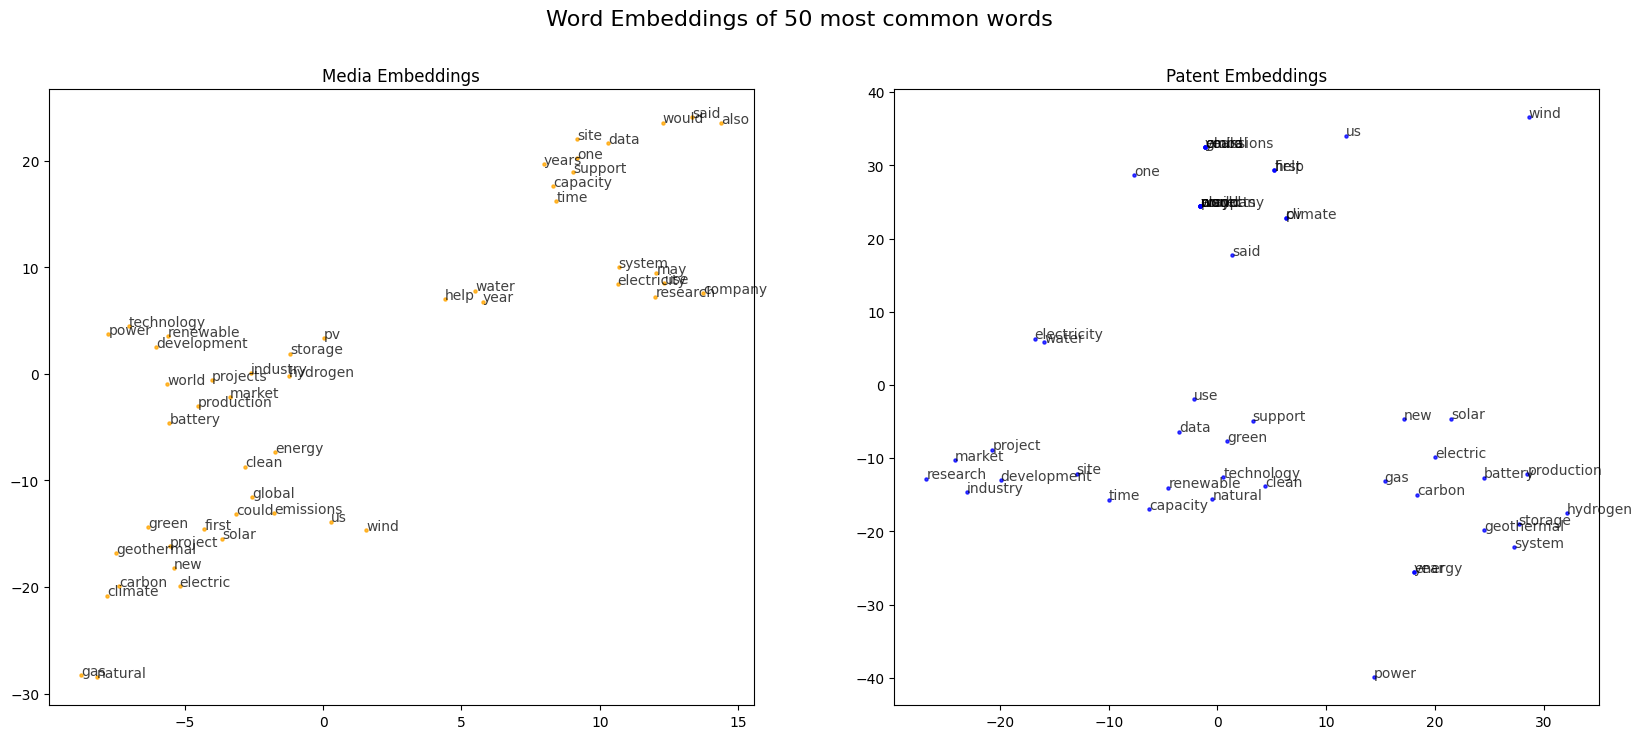

In [222]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

tsne_media = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T_media = tsne_media.fit_transform(media_word_vecs)

ax1.set_title('Media Embeddings')
ax1.scatter(T_media[:, 0], T_media[:, 1], c='Orange', alpha=0.75, s=5)
for label, x, y in zip(labels, T_media[:, 0], T_media[:, 1]):
    ax1.annotate(label,
                 xy=(x, y),
                 xytext=(0, 0),
                 alpha=0.75,
                 textcoords='offset points')

tsne_patents = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T_patents = tsne_patents.fit_transform(patent_word_vecs)

ax2.set_title('Patent Embeddings')
ax2.scatter(T_patents[:, 0], T_patents[:, 1], c='Blue', alpha=0.75, s=5)
for label, x, y in zip(labels, T_patents[:, 0], T_patents[:, 1]):
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(0, 0),
                 alpha=0.75,
                 textcoords='offset points')

plt.suptitle(f'Word Embeddings of {FREQUENCY} most common words', fontsize=16)
plt.show()